In [2]:
import scipy.stats
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import expon, truncexpon, truncnorm, nbinom, norm
import pandas as pd
import time
import torch
from torch import nn
from torch import distributions
from torch import rand
from torch import autograd
from torch import optim

In [3]:
np.random.seed(seed=101)
torch.manual_seed(101)
torch.use_deterministic_algorithms(True)
dtype = torch.float64
device = torch.device("cpu")

In [5]:
data = pd.read_csv('../../data/covid19model.csv')
data

,date,hospit,serial_interval,delay_distr
0,2020-02-17,0,0.046535,1.300600e-02
1,2020-02-18,0,0.087065,3.004645e-02
2,2020-02-19,0,0.112061,4.467391e-02
3,2020-02-20,0,0.119346,5.547300e-02
4,2020-02-21,0,0.114540,6.242203e-02
...,...,...,...,...
402,2021-03-25,38,0.000000,2.817211e-32
403,2021-03-26,31,0.000000,2.349426e-32
404,2021-03-27,39,0.000000,1.959313e-32
405,2021-03-28,32,0.000000,1.633974e-32


In [6]:
def trunc_exponential(scale, upper):
    sample = torch.distributions.exponential.Exponential(1/scale).rsample()
    sample = sample/torch.tensor(1-torch.exp(-upper/scale))
    return sample
# torch.distributions.exponential.Exponential(1/scale).sample()/torch.tensor(1-torch.exp(-upper/scale))

def trunc_normal(mu, sigma, under, upper):
    distribution = torch.distributions.normal.Normal(loc=mu, scale=sigma, validate_args=None)
    normal_sample = distribution.rsample()
    cumulative = distribution.cdf(torch.tensor(upper)) - distribution.cdf(torch.tensor(under))
    return normal_sample/cumulative

# Initialization


In [7]:
cero = torch.tensor(0., requires_grad=False, device=device, dtype=dtype)
num_impute = 6
observed_daily_hospit = torch.tensor(data.hospit, requires_grad=False, device=device, dtype=dtype)
pi = torch.tensor(data.delay_distr, requires_grad=False, device=device, dtype=dtype)
serial_interval = torch.tensor(data.serial_interval, requires_grad=False, device=device, dtype=dtype)
population = torch.tensor(5793636, requires_grad=False, device=device, dtype=dtype)
num_observations = len(observed_daily_hospit)

## Initialize latent variables/parameters

In [16]:
tau= torch.tensor(np.random.exponential(1 / 0.03), requires_grad=True, device=device, dtype=dtype)
phi = torch.tensor(truncnorm.rvs((0 - 25) / 10, (np.inf - 25) / 10, loc=25, scale=10), requires_grad=True, device=device, dtype=dtype) # has to be positive, between 0-50 --> uniform # dispersion (shape) parameter for observations
R0 = torch.tensor(truncnorm.rvs((2 - 3.6) / 0.8, (5 - 3.6) / 0.8, loc=3.6, scale=0.8), requires_grad=True, device=device, dtype=dtype)  # probably gamma or inverse gamma distribution (compare to truncated normal) # initial reproduction number
alpha = torch.tensor(truncnorm.rvs((0 - 1/100) / 1/100, (5/100 - 1/100) / 1/100, loc=1/100, scale=1/100), requires_grad=True, device=device, dtype=dtype) # uniform distribution between (0-5%) # probability to get hospitalized
sigma = torch.tensor(truncnorm.rvs((0 - 0.1) / 0.3, (0.5 - 0.1) / 0.3, loc=0.1, scale=0.3), requires_grad=True, device=device, dtype=dtype)  # positive, tricky, gamma or inverse gamma, log normal  --> try something out, large sigma--> prone to overfitting # standart deviation of random walk step

epsilon_t = torch.zeros(num_observations, device=device)
epsilon_t[0] = torch.distributions.Normal(cero, sigma.detach()).rsample()
for t in range(1, num_observations):
  epsilon_t[t] = torch.distributions.Normal(epsilon_t[t - 1].detach(), sigma.detach()).rsample()
epsilon_t.requires_grad_(True)

tensor([ 0.0294,  0.1030,  0.2288,  0.1504,  0.2225,  0.2134,  0.1990,  0.2332,
         0.1848,  0.2850,  0.2764,  0.2687,  0.2113,  0.1815,  0.2423,  0.1769,
         0.2275,  0.1291,  0.1948,  0.0868, -0.0268, -0.1217, -0.0953, -0.0682,
        -0.1633, -0.1943, -0.1347, -0.1901, -0.1893, -0.2271, -0.2414, -0.1746,
        -0.3116, -0.3370, -0.3230, -0.3840, -0.3525, -0.3530, -0.2667, -0.2904,
        -0.2510, -0.2693, -0.1941, -0.2737, -0.2362, -0.2160, -0.2002, -0.2395,
        -0.2080, -0.2824, -0.2183, -0.2124, -0.3091, -0.2904, -0.3391, -0.2259,
        -0.1923, -0.2197, -0.2697, -0.2986, -0.3698, -0.4126, -0.4617, -0.3950,
        -0.2850, -0.3004, -0.4740, -0.4094, -0.3420, -0.4355, -0.3868, -0.3205,
        -0.3439, -0.2992, -0.3703, -0.4061, -0.3952, -0.4312, -0.3498, -0.2427,
        -0.2486, -0.1780, -0.1282, -0.1916, -0.2012, -0.1841, -0.2093, -0.3705,
        -0.4384, -0.4878, -0.4108, -0.3530, -0.2399, -0.3895, -0.4215, -0.4909,
        -0.4418, -0.3801, -0.5202, -0.48

This is a way to generate the initial params from pytorch distribution directly without truncation.
NOTE: Use either this code block below or above.

In [17]:
dist_tau_t = distributions.exponential.Exponential(torch.tensor([1/0.03], device=device))
#tau_t = dist_tau_t.sample()

dist_y = distributions.exponential.Exponential(tau)
#y = dist_y.sample()

dist_phi = distributions.normal.Normal(loc=torch.tensor([25], device=device), scale=torch.tensor([10], device=device))
#phi = dist_phi.sample()

dist_R0 = distributions.normal.Normal(loc=torch.tensor([3.6], device=device), scale=torch.tensor([0.8], device=device))
#R0 = dist_R0.sample()

dist_alpha = distributions.normal.Normal(loc=torch.tensor([0.01], device=device), scale=torch.tensor([0.01], device=device))
#alpha = dist_alpha.sample()

dist_sigma = distributions.normal.Normal(loc=torch.tensor([0.1], device=device), scale=torch.tensor([0.3], device=device))
#sigma = dist_sigma.sample()

# Define Forward Pass

In [18]:
def calc_prior_loss(tau, phi, R0, alpha, sigma):
  # log likelihood wrt. our prior ("regularisation")
  # ll stands for log-likelihood
  ll = torch.tensor(0.0, device=device)

  #dist_tau_t = distributions.exponential.Exponential(torch.tensor([1/0.03]))
  #ll += dist_tau_t.log_prob(tau).item()

  #dist_y = distributions.exponential.Exponential(tau) #the parameter in the brasket should either be float or tensor, to avoid any inconvienience,
                                                      # I use everything as tensor. NOTE:tau_t is already a tensor.
  #ll += dist_y.log_prob(y).item()

  #dist_phi = distribution.normal.Normal(loc=torch.tensor([25]), scale=torch.tensor([10]))
  ll += dist_phi.log_prob(phi).item()

  #dist_R0 = distribution.normal.Normal(loc=torch.tensor([3.6]), scale=torch.tensor([0.8]))
  ll += dist_R0.log_prob(R0).item()

  #dist_alpha = distribution.normal.Normal(loc=torch.tensor([0.01]), scale=torch.tensor([0.01]))
  ll += dist_alpha.log_prob(alpha).item()

  #dist_sigma = distribution.normal.Normal(loc=torch.tensor([0.1]), scale=torch.tensor([0.3]))
  ll += dist_sigma.log_prob(sigma).item()

  return ll

In [19]:
def seed_init_infect(y):
  # Initialize newly_infected, cumulative_infected, St
  newly_infected = torch.zeros(num_observations, device=device, dtype=dtype)  # number of newly infected
  cumulative_infected = torch.zeros(num_observations, device=device)  # cumulative number of infected
  
  St = torch.zeros(num_observations, device=device)  # fraction of susceptible population
  # seed initial infection / impute first num_impute days
  newly_infected[0:num_impute] = y.clone()
  cumulative_infected[0] = 0.
  cumulative_infected[1:num_impute] = torch.cumsum(newly_infected[0:num_impute - 1].clone(), dim=0)
  St[0:num_impute] = torch.tensor([torch.maximum(population.clone() - x, torch.tensor(0)) / population for x in cumulative_infected[0:num_impute].clone()])
  return newly_infected, cumulative_infected, St

In [20]:
def calc_Rt(R0, epsilon_t, sigma, ll):
  # Initialize eta_t
  eta_t = torch.zeros(num_observations, device=device)  # transformed reproduction number

  # calculate Rt: the basic reproduction number
  # basic reproduction number as a latent random walk
  beta_0 = torch.log(R0)
  eta_t[0] = beta_0
  for t in range(1, num_observations):
      dist_epsilon_t = torch.distributions.Normal(epsilon_t[t - 1], sigma)
      ll += dist_epsilon_t.log_prob(epsilon_t[t - 1])
  eta_t[1:num_observations] = beta_0 + epsilon_t[0:num_observations-1].clone()
  Rt = torch.exp(eta_t)
  return Rt, ll

In [21]:
def calc_infections(cumulative_infected, newly_infected, St, Rt):
  # Initialize effectively_infectious
  effectively_infectious = torch.zeros(num_observations, device=device)  # effective number of infectious individuals
  
  # calculate infections
  for t in range(num_impute, num_observations):
      # Update cumulative newly_infected
      cumulative_infected[t] = cumulative_infected[t - 1].clone() + newly_infected[t - 1].clone()
      # Adjusts for portion of pop that are susceptible
      St[t] = torch.maximum(population.clone() - cumulative_infected[t].clone(), cero) / population.clone()
      # effective number of infectous individuals
      ni_temp = newly_infected[:t].view(1, 1, -1).clone()
      si_temp = torch.flip(serial_interval, (0,))[-t:].view(1, 1, -1)
      effectively_infectious[t] = torch.nn.functional.conv1d(ni_temp, si_temp)
      
      newly_infected[t] = St[t].clone() * Rt[t].clone() * effectively_infectious[t].clone()
  return newly_infected

In [22]:
def calc_hospit(newly_infected, alpha):
  # Initialize expected_daily_hospit
  expected_daily_hospit = torch.zeros(num_observations, device=device)  # expected number of daily hospitalizations

  # calculate expected number of hospitalizations
  expected_daily_hospit[0] = (1e-15) * newly_infected[0].clone()
  for t in range(1, num_observations):
      ni_temp = newly_infected[:t].view(1, 1, -1)
      pi_temp = torch.flip(pi, (0,))[-t-1:-1].view(1, 1, -1)
      expected_daily_hospit[t] = torch.nn.functional.conv1d(ni_temp, pi_temp)
  expected_daily_hospit = alpha * expected_daily_hospit
  return expected_daily_hospit

In [23]:
def compare_results(expected_daily_hospit, phi, ll):
  # compare observed hospitalizations to model results
  # likelihood of the data wrt. to the model

  for i in range(0, num_observations):
      p = 1/(1+ expected_daily_hospit[i]/phi)
      dist = torch.distributions.negative_binomial.NegativeBinomial(phi, p-torch.tensor(2.225e-5))
      ll += dist.log_prob(observed_daily_hospit[i])
  return ll

In [24]:
def forward_pass():
  # Initialize y
  y = trunc_exponential(tau, 1000)

  # Calculate prior loss
  ll = calc_prior_loss(tau, phi, R0, alpha, sigma)
  
  # Seed initial infections
  newly_infected, cumulative_infected, St = seed_init_infect(y)
  
  # Calculate Rt & random walk loss 
  Rt, ll = calc_Rt(R0, epsilon_t, sigma, ll)
  
  # Calculate infections
  newly_infected = calc_infections(cumulative_infected, newly_infected, St, Rt)
  
  # Calculate expected hospitalizations
  expected_daily_hospit = calc_hospit(newly_infected, alpha)
  
  # Compare observed hospitalizations to model results
  ll = compare_results(expected_daily_hospit, phi, ll)
  return expected_daily_hospit, Rt, ll

# Optimization

<ipython-input-6-2bb73561946a>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sample = sample/torch.tensor(1-torch.exp(-upper/scale))
<ipython-input-6-2bb73561946a>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sample = sample/torch.tensor(1-torch.exp(-upper/scale))
<ipython-input-6-2bb73561946a>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sample = sample/torch.tensor(1-torch.exp(-upper/scale))
<ipython-input-6-2bb73561946a>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() o

Time Step: 0|| Loss: 4037.592529296875,  R0:3.9745979210640083, grad: -3084.4575373659713, alpha: 0.010001789756926801 grad: 71805.109375, phi: 12.650174951435243 grad: 89.72178304416816, sigma: 0.06646603793970063 grad 6108.382755841905, epsilon_t.mean: -0.6311532855033875 grad.mean -30.12156867980957
This Run:  1.536325454711914 seconds
Time Step: 5|| Loss: 10459.609375,  R0:3.9745979349036236, grad: 36651.836207309956, alpha: 0.010001722105961688 grad: -152456.359375, phi: 12.650174950091927 grad: 887.2318340516141, sigma: 0.06646600739780567 grad 6108.385562714002, epsilon_t.mean: -0.6176380515098572 grad.mean 357.92706298828125
This Run:  0.772942066192627 seconds
Time Step: 10|| Loss: 4312.6044921875,  R0:3.9745979217016374, grad: -1003.0384554823264, alpha: 0.01000113515590032 grad: 34276.6640625, phi: 12.650174948688758 grad: 159.5526224835623, sigma: 0.06646597685604938 grad 6108.388369575956, epsilon_t.mean: -0.630530595779419 grad.mean -9.795269012451172
This Run:  0.7061467

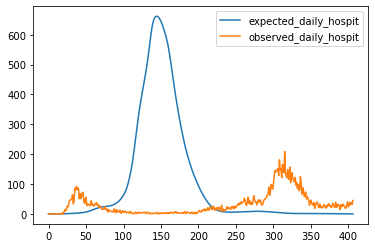

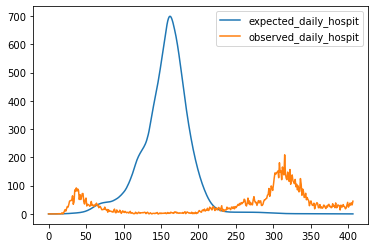

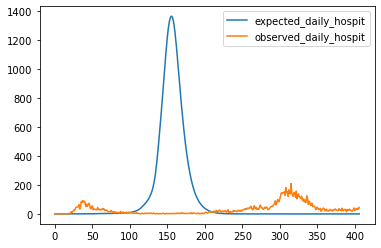

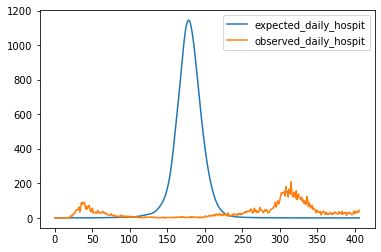

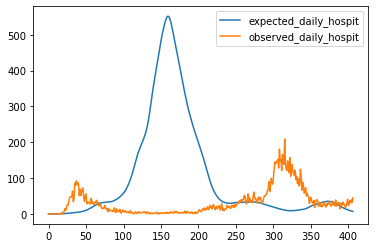

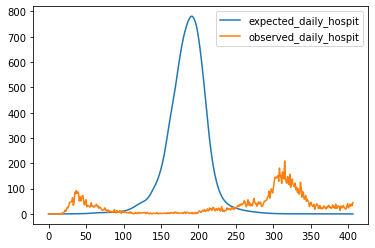

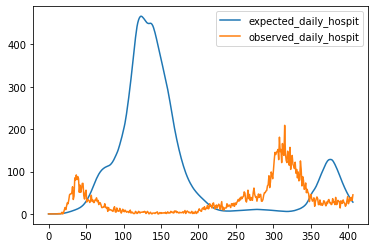

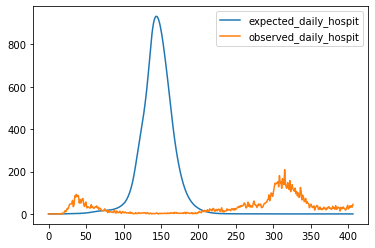

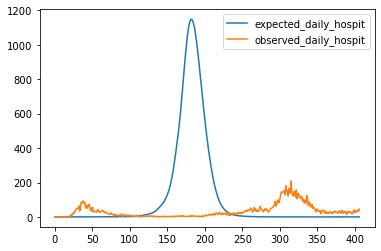

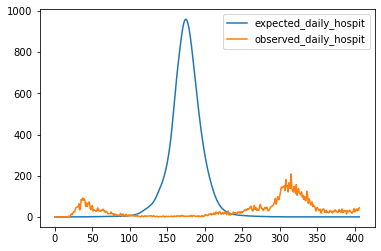

In [26]:
learning_rate = 1e-12
epochs = 100
complete_time = time.time()

for k in range (epochs):
    start_time = time.time()
    decay = (1 - (k / (epochs*1e5))) ** 2
    learning_rate = learning_rate * decay

    # forward pass - calculate expected_daily_hospit
    expected_daily_hospit, Rt, ll = forward_pass()

    #backward pass
    loss = -ll
    loss.backward()

    if k%5 == 0:
      print(f'Time Step: {k}|| Loss: {loss},  R0:{R0}, grad: {R0.grad}, alpha: {alpha} grad: {alpha.grad}, phi: {phi} grad: {phi.grad}, sigma: {sigma} grad {sigma.grad}, epsilon_t.mean: {epsilon_t.mean()} grad.mean {epsilon_t.grad.mean()}')
      print("This Run:  %s seconds" % (time.time() - start_time))
    with torch.no_grad(): # this part is SGD. can also replace with loss.step
        tau -= learning_rate * tau.grad
        phi -= learning_rate * phi.grad 
        R0 -= learning_rate * R0.grad 
        alpha -= learning_rate * alpha.grad 
        sigma -= learning_rate * sigma.grad 
        epsilon_t -= learning_rate * epsilon_t.grad * 1e+8

        tau.grad = None
        phi.grad = None
        R0.grad = None
        alpha.grad = None
        sigma.grad = None
        epsilon_t.grad = None

    
    if k%10 == 0:
      plt.plot(expected_daily_hospit.cpu().detach().numpy(), label='expected_daily_hospit')
      plt.plot(observed_daily_hospit.cpu().detach().numpy(), label='observed_daily_hospit')
      plt.legend()
      plt.show()


print("Complete Run:  %s seconds" % (time.time() - complete_time))